In [73]:
import warnings 
import numpy as np
import pandas as pd
from bokeh.io import show, output_notebook, output_file
from bokeh.models import BoxZoomTool, ResetTool, PanTool, HoverTool
from bokeh.models import Plot, Range1d, MultiLine, Circle
from bokeh.models.graphs import from_networkx, NodesAndLinkedEdges, EdgesAndLinkedNodes
from sklearn.neighbors import DistanceMetric
import networkx as nx
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
warnings.filterwarnings('ignore')

In [74]:
df=pd.read_json('https://gist.githubusercontent.com/ozdemirburak/4821a26db048cc0972c1beee48a408de/raw/4754e5f9d09dade2e6c461d7e960e13ef38eaa88/cities_of_turkey.json')
df.columns=['plaka', 'il', 'lat', 'lon', 'nüfus', 'reg.']


In [75]:
df.sample(5)

,plaka,il,lat,lon,nüfus,reg.
53,54,Sakarya,40.6940,30.4358,953181,Marmara
38,39,Kırklareli,41.7333,27.2167,346973,Marmara
36,37,Kastamonu,41.3887,33.7827,372633,Karadeniz
19,20,Denizli,37.7765,29.0864,993442,Ege
62,63,Şanlıurfa,37.1591,38.7969,1892320,Güneydoğu Anadolu


In [76]:
df=df.reset_index()
dfr = df[['il', 'lat', 'lon']]
dfr['il']=dfr['il'].str.lower()
dfr['lat'] = np.radians(dfr.lat)
dfr['lon'] = np.radians(dfr.lon)
dist = DistanceMetric.get_metric('haversine')
dist.pairwise(dfr[['lat','lon']].to_numpy())*6373 
pairwise=pd.DataFrame(dist.pairwise(dfr[['lat','lon']].to_numpy())*6373,  columns=dfr.il.unique(), index=dfr.il.unique())
mesafe = pairwise.unstack()
mesafe.index.rename(['şehir A', 'şehir B'], inplace=True)
mesafe = mesafe.to_frame('Mesafe ').reset_index()
mesafe.sample(5)

,şehir A,şehir B,Mesafe
463,ankara,tekirdağ,466.874988
3288,kocaeli,muş,1034.191472
4419,samsun,kahramanmaraş,415.596515
2954,kastamonu,kırklareli,547.681558
1011,bitlis,kırşehir,694.437925


In [79]:
long_form.to_csv(r'edge_list.txt', header=None, index=None, sep=' ', mode='a')

In [81]:
G = nx.read_weighted_edgelist('edge_list.txt', delimiter =" ") 
for i in list(G.nodes()): 
    G.nodes[i]['nüfus'] = pd.Series(df['nüfus'].values,index=df['il']).to_dict()[i] 

In [82]:
size=0.5
l=0.5
def box_cox_normalization(node_size):
    from math import ceil
    from math import pow
    compressed_point=(pow(node_size, l) -1)/l
    return ceil(size*compressed_point)

In [83]:
new_sizes=dict(map(lambda node: (node[0] , box_cox_normalization(node[1])), dict(G.degree).items()))
color=dict(map(lambda node: (node[0], 'red' if node[1]>500 else 'blue'), dict(G.degree).items()))
nx.set_node_attributes(G, dict(G.degree), 'connections')
nx.set_node_attributes(G, new_sizes, 'node_size')
plot=Plot(plot_width=700, plot_height=500, x_range=Range1d(-1.1, 1.1), 
          y_range=Range1d(-1.1, 1.1))
plot.add_tools(BoxZoomTool(), ResetTool(), PanTool(), HoverTool(tooltips=[('name', '@name')]))
graph_renderer=from_networkx(G, nx.spring_layout, scale=1, center=(0, 0))

graph_renderer.node_renderer.glyph=Circle(size='node_size')
graph_renderer.inspection_policy = NodesAndLinkedEdges()
graph_renderer.edge_renderer.glyph=MultiLine(line_alpha=0.4, line_width=0.4)

graph_renderer.node_renderer.data_source.data['name'] = df['il'].values
plot.renderers.append(graph_renderer)

output_notebook()

#output_file("graph.html")

show(plot)

Loading BokehJS ...

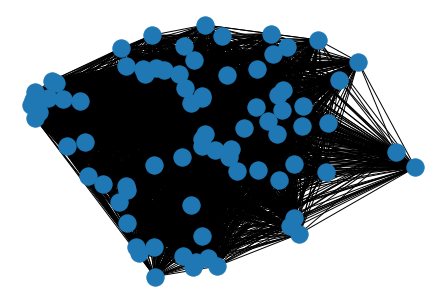

In [84]:
nx.draw(G)